<a href="https://colab.research.google.com/github/jufabeck2202/KI-Lab/blob/main/%5BKI-Lab2021%5D%20Assignment%201%20OWCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment:
Preparation:
1. Checkout the notebook 0_Simple_NN.ipynb from Git, which describes how to
setup a simple feedforward network on some fake data. Try to understand
everything and execute the notebook. Ask on the chat if sth. is unclear.
2. Read through this blog post: https://nextjournal.com/gkoehler/pytorch-mnist
It shows how to work with data loaders, how to load the MNIST dataset and how
training is done in batches (using data loaders). 

Task:
1. Load the MNIST dataset into train and test data loaders. Use the same
parameters and apply the same transformations like described in the blog post.
2. Create a feedforward neural network consisting of an input layer, one hidden
layer of size 100 and an output layer (same structure as in Simple_NN.ipynb).
For training on the MNIST dataset you need to change the following:
  - Adjust the size of the input layer to be able to take in the MNIST data (hint: you
must adjust the tensor format from the MNIST data into a flat structure).
  - Use log_softmax as activation function for the output layer (as in the blog).
Note: Do not use a CNN like they do in the blog post! Use Relu as activation
function for the hidden layer.
3. Train your network on the training data for 50 epochs using the negative log
likelihood loss (like in the blog). Create a plot of the training loss (like in the blog
but without the test loss).
4. Test the network on the MNIST test data and give out accuracy and loss.
5. Find out how the model can be trained on the GPU instead of the CPU. Compare the
training time between CPU and GPU. (Note: Do not except too much improvement on
this small data set).
6. Repeat step 1. to 4. and see what happens when you try out:
  1. Two different hidden layer sizes.
  2. Using a normal softmax as activation function together with a CrossEntropyLoss.

In [27]:
#Import Libraries
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time


# Parameter

In [28]:
n_epochs = 50
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 #0.1 
momentum = 0.5
log_interval = 10

random_seed = 1
GPU_ON = True
torch.backends.cudnn.enabled = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(random_seed)
print(device)

GPU_time = 0
CPU_time = 0
network = None
optimizer = None

figures = []



cuda:0


# Download MNIST Dataset

In [29]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

# Explore Dataset

In [30]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [31]:
example_data.shape

torch.Size([1000, 1, 28, 28])

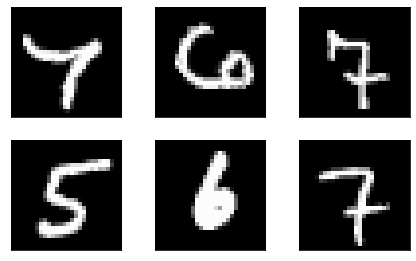

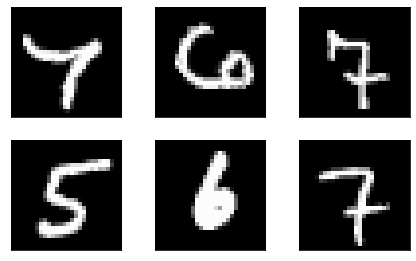

In [32]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  #plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Create Neural Network

In [33]:
class Net(nn.Module):
    def __init__(self, hidden_size, use_relu):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(28*28*1, hidden_size)
        self.output = torch.nn.Linear(hidden_size, 10)
        self.use_relu = use_relu

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = x.flatten(start_dim = 1)
        
        if self.use_relu:
          x = self.hidden(x).clamp(min=0)
        else:
          x = F.softmax(self.hidden(x))

        x = F.log_softmax(self.output(x))
        return x

In [34]:
def defineNetwork(hidden_size, use_relu):
  global network
  network = Net(hidden_size, use_relu)
  if GPU_ON:
    network.cuda()
    
  global optimizer
  optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [35]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      if GPU_ON:
        data = data.cuda()
        target = target.cuda()
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  
  return ('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  

In [36]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    if GPU_ON:
      data = data.cuda()
      target = target.cuda()
    output = network(data)
    loss = F.nll_loss(output, target)
    #F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [37]:
def createPlot(activation_function, time):
  temp = plt.figure()
  plt.legend(['Train Loss'], loc='upper right')
  plt.xlabel("%s" % (network)+" "+ activation_function+ " "+time)
  plt.ylabel('negative log likelihood loss')
  plt.plot(train_counter, train_losses, color='blue')
  plt.close()
  return temp

# Training

##### Training GPU VS *CPU*

In [38]:

#CPU:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = False
defineNetwork(100, True)

CPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

CPU_time = time.time() - CPU_time

plot = createPlot("Relu as Activation","CPU: %s seconds" % (CPU_time))
figures.append(plot)

#GPU
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

print("--- CPU: %s seconds ---" % (CPU_time))
print("--- GPU: %s seconds ---" % (GPU_time))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [32000/60000 (53%)]	Loss: 0.001933
Train Epoch: 49 [32640/60000 (54%)]	Loss: 0.013146
Train Epoch: 49 [33280/60000 (55%)]	Loss: 0.003297
Train Epoch: 49 [33920/60000 (57%)]	Loss: 0.005228
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.007572
Train Epoch: 49 [35200/60000 (59%)]	Loss: 0.007480
Train Epoch: 49 [35840/60000 (60%)]	Loss: 0.016998
Train Epoch: 49 [36480/60000 (61%)]	Loss: 0.032149
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.004900
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.013750
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.004103
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.007328
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.035532
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.007066
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.008401
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.009470
Train Epoch: 49 [42240/60000 (70%)]	Loss: 0.012861
Train Epoch: 49 [42880/60000 (71%)]	Loss: 0.006792
Train Epoch: 49

##### Training SoftMax 100 & 1000 Layers

In [39]:
#softmax 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, False)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

GPU_time = time.time() - GPU_time

plot = createPlot("Softmax as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

#softmax 1000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(1000, False)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

GPU_time = time.time() - GPU_time

plot = createPlot("Softmax as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [30720/60000 (51%)]	Loss: 0.880298
Train Epoch: 49 [31360/60000 (52%)]	Loss: 0.787124
Train Epoch: 49 [32000/60000 (53%)]	Loss: 0.866899
Train Epoch: 49 [32640/60000 (54%)]	Loss: 0.957713
Train Epoch: 49 [33280/60000 (55%)]	Loss: 0.709713
Train Epoch: 49 [33920/60000 (57%)]	Loss: 0.826186
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.772953
Train Epoch: 49 [35200/60000 (59%)]	Loss: 0.872904
Train Epoch: 49 [35840/60000 (60%)]	Loss: 0.873891
Train Epoch: 49 [36480/60000 (61%)]	Loss: 1.085444
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.806151
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.815413
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.914452
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.950903
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.939302
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.850358
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.904679
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.935262
Train Epoch: 49

##### 100, 1000 & 10 000 Layers

In [40]:
#Relu 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(100, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

#Relu 1000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(1000, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

#Relu 10000
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

GPU_ON = True
defineNetwork(10000, True)

GPU_time = time.time()

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

GPU_time = time.time() - GPU_time

plot = createPlot("Relu as Activation","GPU: %s seconds" % (GPU_time))
figures.append(plot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Train Epoch: 49 [30720/60000 (51%)]	Loss: 0.005491
Train Epoch: 49 [31360/60000 (52%)]	Loss: 0.000627
Train Epoch: 49 [32000/60000 (53%)]	Loss: 0.003595
Train Epoch: 49 [32640/60000 (54%)]	Loss: 0.004528
Train Epoch: 49 [33280/60000 (55%)]	Loss: 0.009535
Train Epoch: 49 [33920/60000 (57%)]	Loss: 0.004891
Train Epoch: 49 [34560/60000 (58%)]	Loss: 0.002274
Train Epoch: 49 [35200/60000 (59%)]	Loss: 0.007316
Train Epoch: 49 [35840/60000 (60%)]	Loss: 0.003931
Train Epoch: 49 [36480/60000 (61%)]	Loss: 0.016818
Train Epoch: 49 [37120/60000 (62%)]	Loss: 0.015564
Train Epoch: 49 [37760/60000 (63%)]	Loss: 0.004210
Train Epoch: 49 [38400/60000 (64%)]	Loss: 0.004310
Train Epoch: 49 [39040/60000 (65%)]	Loss: 0.004143
Train Epoch: 49 [39680/60000 (66%)]	Loss: 0.011654
Train Epoch: 49 [40320/60000 (67%)]	Loss: 0.003583
Train Epoch: 49 [40960/60000 (68%)]	Loss: 0.004037
Train Epoch: 49 [41600/60000 (69%)]	Loss: 0.008391
Train Epoch: 49

# Evaluation

##### GPU VS CPU

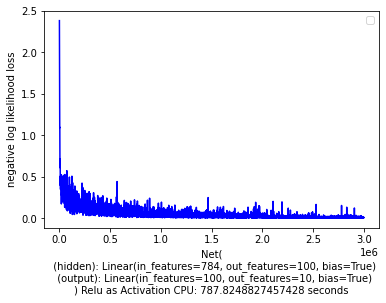

In [41]:
figures[0]

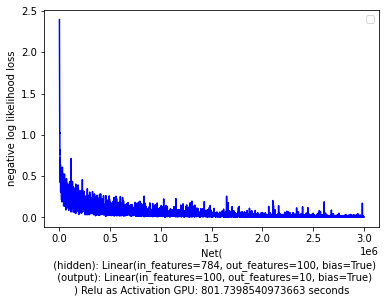

In [42]:
figures[1]

##### Softmax

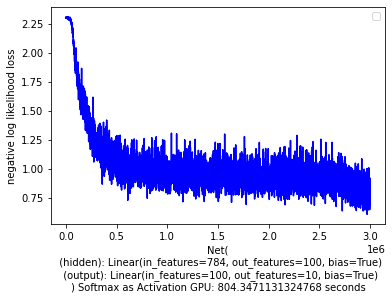

In [43]:
figures[2]

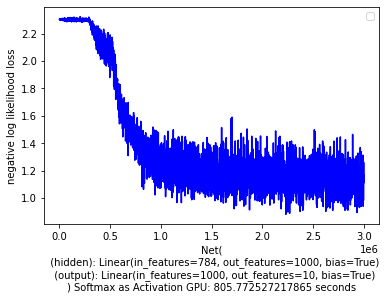

In [44]:
figures[3]

##### Relu 100, 1000, 10 000

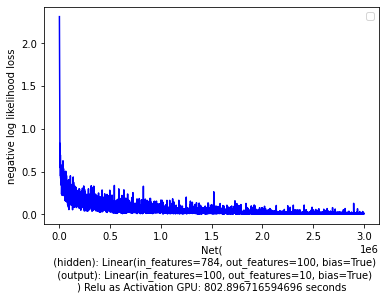

In [45]:
figures[4]

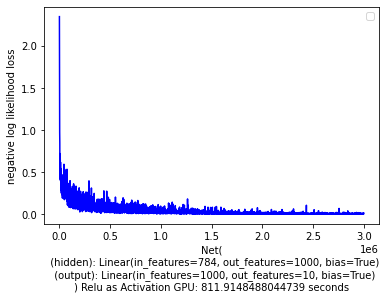

In [46]:
figures[5]

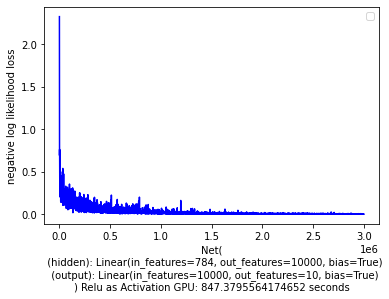

In [47]:
figures[6]